This notebook explains the trained XGBoost fraud detection model using SHAP, validates explanation stability, and translates model reasoning into human-readable reason codes suitable for business dashboards and production APIs.

In [6]:
!pip install shap



  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/c1/29/021db5e35636aae199a40cfdbb87794432bbe9660c5bdbff0867d754e400/shap-0.50.0-cp312-cp312-win_amd64.whl.metadata
  Using cached shap-0.50.0-cp312-cp312-win_amd64.whl.metadata (25 kB)
  Obtaining dependency information for numba>=0.54 from https://files.pythonhosted.org/packages/af/fd/6540456efa90b5f6604a86ff50dabefb187e43557e9081adcad3be44f048/numba-0.63.1-cp312-cp312-win_amd64.whl.metadata
  Using cached numba-0.63.1-cp312-cp312-win_amd64.whl.metadata (3.0 kB)
  Obtaining dependency information for cloudpickle from https://files.pythonhosted.org/packages/88/39/799be3f2f0f38cc727ee3b4f1445fe6d5e4133064ec2e4115069418a5bb6/cloudpickle-3.1.2-py3-none-any.whl.metadata
  Using cached cloudpickle-3.1.2-py3-none-any.whl.metadata (7.1 kB)
  Obtaining dependency information for llvmlite<0.47,>=0.46.0dev0 from https://files.pythonhosted.org/packages/2a/6b/d139535d7590a1bba1ceb68751bef22fadaa5b815bbdf0e858e3


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd
import numpy as np
import shap
import joblib

import matplotlib.pyplot as plt


c:\Users\BIT\OneDrive\Desktop\Fraud- Detection\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
xgb_model = joblib.load("../artifacts/xgb_model_v1.pkl")
feature_cols = joblib.load("../artifacts/xgb_features_v1.pkl")


In [9]:
trans = pd.read_csv("../data/train_transaction.csv")
ident = pd.read_csv("../data/train_identity.csv")

trans = trans.sort_values("TransactionDT").reset_index(drop=True)


In [11]:
# ---------- Feature Engineering (EXACTLY as Notebook 04) ----------

# UID
trans["uid"] = trans["card1"].astype(str) + "_" + trans["addr1"].astype(str)

# Velocity
trans["uid_txn_count"] = trans.groupby("uid").cumcount()

# Abnormal amount
uid_avg_amt = (
    trans.groupby("uid")["TransactionAmt"]
    .expanding()
    .mean()
    .shift()
    .reset_index(level=0, drop=True)
)

trans["uid_avg_amt"] = uid_avg_amt
trans["amt_vs_uid_avg"] = trans["TransactionAmt"] / trans["uid_avg_amt"]

# Recency
trans["uid_prev_dt"] = trans.groupby("uid")["TransactionDT"].shift()
trans["uid_time_since_last"] = trans["TransactionDT"] - trans["uid_prev_dt"]

# Identity presence
trans["has_identity"] = trans["TransactionID"].isin(
    ident["TransactionID"]
).astype(int)

# M-features encoding
m_cols = [c for c in trans.columns if c.startswith("M")]
for c in m_cols:
    trans[c] = trans[c].map({"T": 1, "F": 0}).fillna(-1)

# Merge identity
trans = trans.merge(
    ident,
    on="TransactionID",
    how="left"
)

# Encode identity categories
identity_cols = ["DeviceType", "DeviceInfo"]
for c in identity_cols:
    trans[c] = trans[c].astype("category").cat.codes


In [12]:

split_idx = int(len(trans) * 0.8)
val_df = trans.iloc[split_idx:].copy()

# Sample for SHAP (stable & fast)
shap_sample = val_df.sample(n=2000, random_state=42)
X_shap = shap_sample[feature_cols]


In [13]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_shap)


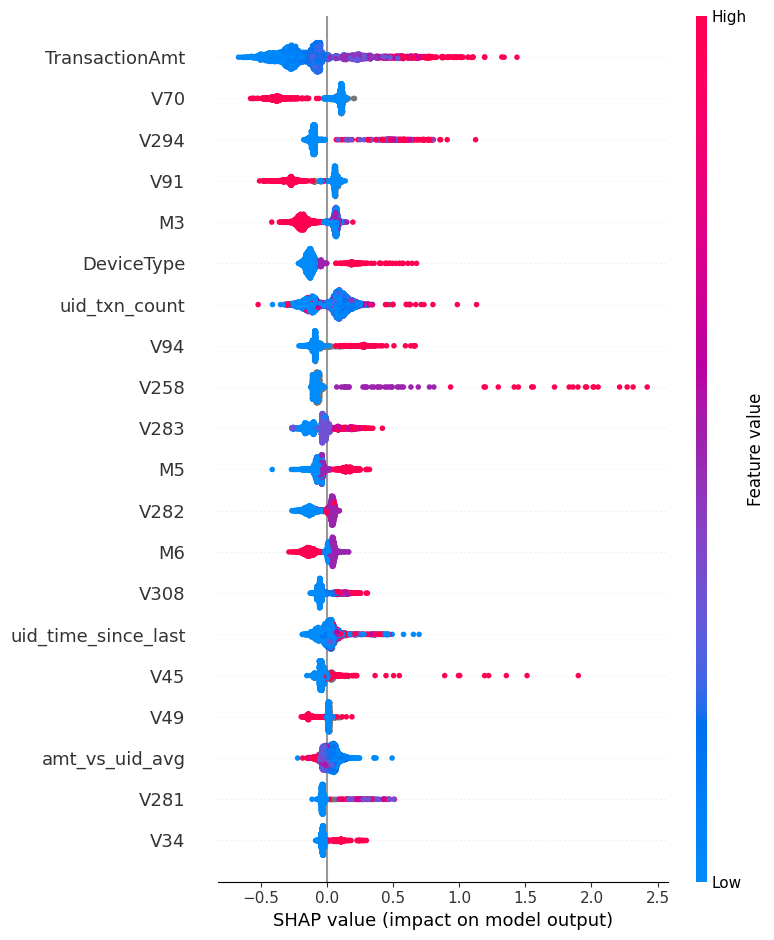

In [14]:
shap.summary_plot(
    shap_values,
    X_shap,
    max_display=20,
    show=True
)


In [15]:
shap_sample["pred_prob"] = xgb_model.predict_proba(X_shap)[:, 1]
high_risk_row = shap_sample.sort_values("pred_prob", ascending=False).iloc[0]

row_idx = high_risk_row.name


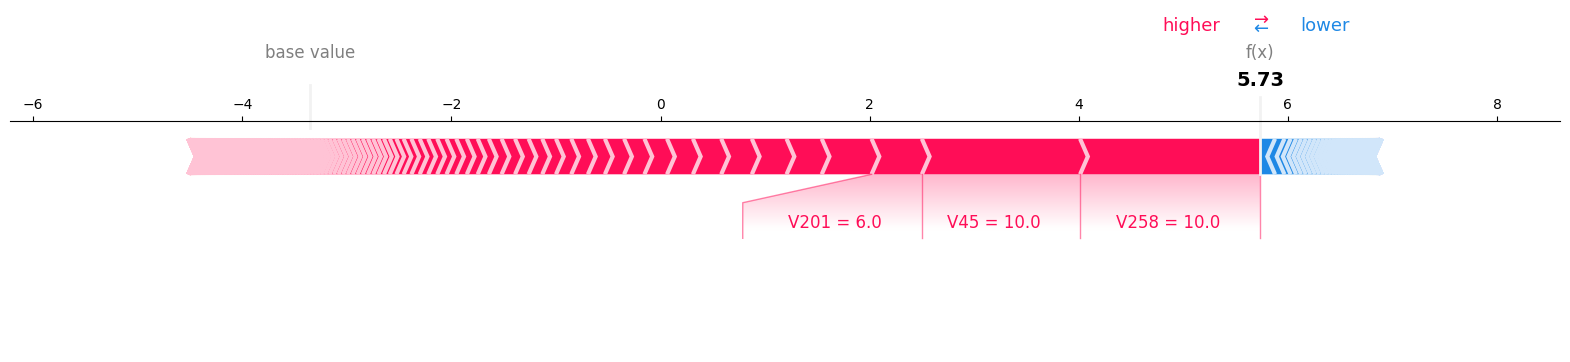

In [16]:
shap.force_plot(
    explainer.expected_value,
    shap_values[X_shap.index.get_loc(row_idx)],
    X_shap.loc[row_idx],
    matplotlib=True
)


In [17]:
REASON_MAP = {
    "uid_txn_count": "Multiple transactions in a short time",
    "TransactionAmt": "High transaction amount",
    "amt_vs_uid_avg": "Amount unusually high compared to past behavior",
    "uid_time_since_last": "Unusual transaction timing",
    "has_identity": "Transaction linked to suspicious device behavior",
    "DeviceType": "New or uncommon device type used",
    "DeviceInfo": "Unrecognized device fingerprint"
}


In [18]:
def map_v_feature(feature):
    return "Unusual behavioral pattern detected"


In [26]:
def generate_reason_codes(row, shap_row, top_k=3):
    feature_contrib = pd.Series(shap_row, index=feature_cols)
    feature_contrib = feature_contrib.sort_values(ascending=False)

    reasons = []
    used_generic_v = False

    for feat in feature_contrib.index:
        if feature_contrib[feat] <= 0:
            continue

        # Priority: interpretable features
        if feat in REASON_MAP:
            reason = REASON_MAP[feat]
            if reason not in reasons:
                reasons.append(reason)

        # Generic V-feature handling (only once)
        elif feat.startswith("V") and not used_generic_v:
            reasons.append("Unusual behavioral pattern detected")
            used_generic_v = True

        if len(reasons) == top_k:
            break

    return reasons


In [27]:
idx = X_shap.index.get_loc(row_idx)
reasons = generate_reason_codes(
    X_shap.loc[row_idx],
    shap_values[idx]
)

reasons


['Unusual behavioral pattern detected',
 'Multiple transactions in a short time',
 'New or uncommon device type used']

In [28]:
def risk_bucket(prob):
    if prob >= 0.85:
        return "Very High Risk"
    elif prob >= 0.65:
        return "High Risk"
    elif prob >= 0.35:
        return "Medium Risk"
    else:
        return "Low Risk"


In [29]:
prob = high_risk_row["pred_prob"]
risk_bucket(prob)


'Very High Risk'

In [30]:
decision = {
    "risk_level": risk_bucket(prob),
    "reasons": reasons,
    "recommended_action": "Hold transaction and request verification"
}

decision


{'risk_level': 'Very High Risk',
 'reasons': ['Unusual behavioral pattern detected',
  'Multiple transactions in a short time',
  'New or uncommon device type used'],
 'recommended_action': 'Hold transaction and request verification'}

In [25]:
top_rows = shap_sample.sort_values("pred_prob", ascending=False).head(10)

for idx in top_rows.index:
    reasons = generate_reason_codes(
        X_shap.loc[idx],
        shap_values[X_shap.index.get_loc(idx)]
    )
    print(reasons)


['Unusual behavioral pattern detected', 'Unusual behavioral pattern detected', 'Unusual behavioral pattern detected']
['Unusual behavioral pattern detected', 'Unusual behavioral pattern detected', 'High transaction amount']
['Unusual behavioral pattern detected', 'Unusual behavioral pattern detected', 'Unusual behavioral pattern detected']
['Unusual behavioral pattern detected', 'Unusual behavioral pattern detected', 'Unusual behavioral pattern detected']
['Unusual behavioral pattern detected', 'Unusual behavioral pattern detected', 'Unusual behavioral pattern detected']
['Unusual behavioral pattern detected', 'Unusual behavioral pattern detected', 'Unusual behavioral pattern detected']
['Unusual behavioral pattern detected', 'Unusual behavioral pattern detected', 'Unusual behavioral pattern detected']
['Unusual behavioral pattern detected', 'Unusual behavioral pattern detected', 'Unusual behavioral pattern detected']
['Unusual behavioral pattern detected', 'Unusual behavioral pattern 

In [31]:
joblib.dump(REASON_MAP, "../artifacts/reason_map.pkl")
joblib.dump(risk_bucket, "../artifacts/risk_bucket_fn.pkl")


['../artifacts/risk_bucket_fn.pkl']